## This notebook presents the reproducible procedure that we followed in comparing the performance of Hybrid Quantum Neural Networks-Parallel and Classical Convolutional Neural Networks on the APTOS-2019 dataset. The APTOS dataset is a diabetic-retinopathy dataset with 3662 fundus images. The dataset was produced in France and is labeled with five-category classification (no diabetic retinopathy, mild diabetic retinopathy, moderate diabetic retinopathy, severe diabetic retinopathy, and proliferative diabetic retinopathy).

### Installing and Importing Dependencies

In [ ]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 90.7 MB/s eta 0:00:00


In [ ]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
from google.colab import drive
import cv2
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Sampler
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms
from PIL import Image
import time
import os
import copy
from torch.optim.lr_scheduler import CosineAnnealingLR
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve,
    precision_recall_curve, auc, ConfusionMatrixDisplay
)
from sklearn.preprocessing import label_binarize
import random
from itertools import cycle

os.environ["OMP_NUM_THREADS"] = "1"

In [ ]:
import matplotlib.pyplot as plt
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
MODEL_SAVE_PATH = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/APTOS_models_QNN-Parallel/"

### General Training, Validation, Testing Functions

In [ ]:
import torchvision
from torchvision import datasets, transforms

In [ ]:
def train_model(model, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_probs = []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        probs = torch.softmax(outputs, dim=1)
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.detach().cpu().numpy())



    avg_train_loss = train_loss / len(train_loader.dataset)
    accuracy = correct / total * 100

    aurocs = []
    for i in range(probs.shape[1]):
        try:
            auroc = roc_auc_score([1 if label == i else 0 for label in all_labels], [prob[i] for prob in all_probs])
            aurocs.append(auroc)
        except ValueError:
            aurocs.append(0)

    avg_auroc = sum(aurocs) / len(aurocs)

    return avg_train_loss, accuracy, avg_auroc

In [ ]:
def validate_model(model, valid_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            probs = torch.softmax(outputs, dim=1)
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.detach().cpu().numpy())

    avg_val_loss = val_loss / len(valid_loader.dataset)
    accuracy = correct / total * 100
    aurocs = []
    for i in range(probs.shape[1]):
        try:
            auroc = roc_auc_score([1 if label == i else 0 for label in all_labels], [prob[i] for prob in all_probs])
            aurocs.append(auroc)
        except ValueError:
            aurocs.append(0)

    avg_auroc = sum(aurocs) / len(aurocs)

    return avg_val_loss, accuracy, avg_auroc

In [ ]:
import pickle

def train_validate_model(n_epochs, model, model_name, train_loader, valid_loader, seed, quantum=False):

  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

  def adjust_learning_rate(optimizer, epoch, lr_warmup_epochs, lr_max):
        if epoch < lr_warmup_epochs:
            lr = lr_max * (epoch + 1) / lr_warmup_epochs
        else:
            lr = lr_max
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

  scheduler = CosineAnnealingLR(optimizer, T_max=n_epochs - 10, eta_min=1e-6)

  best_val_loss = float('inf')
  best_model_weights = model.state_dict()
  epochs_without_improvement = 0
  early_stopping_patience = 10

  train_losses = []
  train_accuracies = []
  val_losses = []
  val_accuracies = []
  train_aucs = []
  val_aucs = []

  lr_max = 5e-4
  lr_warmup_epochs = 10

  for epoch in range(n_epochs):
      print(f'Epoch [{epoch+1}/{n_epochs}]')

      adjust_learning_rate(optimizer, epoch, lr_warmup_epochs, lr_max)

      train_loss, train_accuracy, train_auroc = train_model(model, train_loader, optimizer, criterion)
      val_loss, val_accuracy, val_auroc = validate_model(model, valid_loader, criterion)


      print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Training AUROC: {train_auroc:.4f}')
      print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%, Validation AUROC: {val_auroc:.4f}')
      train_losses.append(train_loss)
      train_accuracies.append(train_accuracy)
      train_aucs.append(train_auroc)
      val_losses.append(val_loss)
      val_accuracies.append(val_accuracy)
      val_aucs.append(val_auroc)

      if epoch >= lr_warmup_epochs:
            scheduler.step()

      if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_weights = model.state_dict()
            epochs_without_improvement = 0  # Reset counter

      else:
            epochs_without_improvement += 1

      if epochs_without_improvement >= early_stopping_patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break


  model.load_state_dict(best_model_weights)

  if quantum:
    torch.save(model.state_dict(), os.path.join(MODEL_SAVE_PATH, f'{model_name}_{seed}.pth'))
  else:
    torch.save(model, os.path.join(MODEL_SAVE_PATH, f'{model_name}_{seed}.pth'))

  metrics = {
        "train_losses": train_losses,
        "train_accuracies": train_accuracies,
        "train_aucs": train_aucs,
        "val_losses": val_losses,
        "val_accuracies": val_accuracies,
        "val_aucs": val_aucs
    }

  with open(os.path.join(MODEL_SAVE_PATH, f'{model_name}_{seed}_metrics.pkl'), 'wb') as f:
        pickle.dump(metrics, f)

  return model, train_losses, train_accuracies, val_losses, val_accuracies, train_aucs, val_aucs

In [ ]:
import math
import matplotlib.pyplot as plt

def plot(quantum_loss, normal_loss, quantum_acc, normal_acc, quantum_auc, normal_auc):
    plt.style.use("default")

    loss_min = math.floor(min(min(quantum_loss), min(normal_loss)) * 10) / 10
    loss_max = math.ceil(max(max(quantum_loss), max(normal_loss)) * 10) / 10

    acc_min = math.floor(min(min(quantum_acc), min(normal_acc)) * 10) / 10
    acc_max = math.ceil(max(max(quantum_acc), max(normal_acc)) * 10) / 10

    auc_min = math.floor(min(min(quantum_auc), min(normal_auc)) * 10) / 10
    auc_max = math.ceil(max(max(quantum_auc), max(normal_auc)) * 10) / 10

    plt.figure(figsize=(6, 3))
    plt.plot(quantum_loss, label="With quantum layer")
    plt.plot(normal_loss, label="Without quantum layer")
    plt.ylabel("Loss")
    plt.ylim([loss_min, loss_max])
    plt.xlabel("Epoch")
    plt.legend()
    plt.title("Loss vs. Epoch")
    plt.show()

    plt.figure(figsize=(6, 3))
    plt.plot(quantum_acc, label="With quantum layer")
    plt.plot(normal_acc, label="Without quantum layer")
    plt.ylabel("Accuracy")
    plt.ylim([acc_min, acc_max])
    plt.xlabel("Epoch")
    plt.legend()
    plt.title("Accuracy vs. Epoch")
    plt.show()

    plt.figure(figsize=(6, 3))
    plt.plot(quantum_auc, label="With quantum layer")
    plt.plot(normal_auc, label="Without quantum layer")
    plt.ylabel("ROCAUC")
    plt.ylim([auc_min, auc_max])
    plt.xlabel("Epoch")
    plt.legend()
    plt.title("ROCAUC vs. Epoch")
    plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.preprocessing import label_binarize
from itertools import cycle


def test(model_hybrid, model_normal, test_loader, num_classes):
    model_hybrid.eval()
    model_normal.eval()

    all_labels = []
    all_preds_hybrid = []
    all_preds_normal = []
    all_probs_hybrid = []
    all_probs_normal = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)


            outputs_hybrid = model_hybrid(images)
            _, preds_hybrid = torch.max(outputs_hybrid, 1)
            probs_hybrid = torch.softmax(outputs_hybrid, dim=1)
            # Normal model predictions
            outputs_normal = model_normal(images)
            _, preds_normal = torch.max(outputs_normal, 1)
            probs_normal = torch.softmax(outputs_normal, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_preds_hybrid.extend(preds_hybrid.cpu().numpy())
            all_preds_normal.extend(preds_normal.cpu().numpy())
            all_probs_hybrid.extend(probs_hybrid.cpu().numpy())
            all_probs_normal.extend(probs_normal.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds_hybrid = np.array(all_preds_hybrid)
    all_preds_normal = np.array(all_preds_normal)
    all_probs_hybrid = np.array(all_probs_hybrid)
    all_probs_normal = np.array(all_probs_normal)


    accuracy_hybrid = accuracy_score(all_labels, all_preds_hybrid)
    accuracy_normal = accuracy_score(all_labels, all_preds_normal)


    f1_hybrid = f1_score(all_labels, all_preds_hybrid, average='weighted')
    f1_normal = f1_score(all_labels, all_preds_normal, average='weighted')


    if num_classes == 2:
        precision_hybrid = precision_score(all_labels, all_preds_hybrid, pos_label=1)
        recall_hybrid = recall_score(all_labels, all_preds_hybrid, pos_label=1)
        precision_normal = precision_score(all_labels, all_preds_normal, pos_label=1)
        recall_normal = recall_score(all_labels, all_preds_normal, pos_label=1)
    else:
        precision_hybrid = precision_score(all_labels, all_preds_hybrid, average='weighted')
        recall_hybrid = recall_score(all_labels, all_preds_hybrid, average='weighted')
        precision_normal = precision_score(all_labels, all_preds_normal, average='weighted')
        recall_normal = recall_score(all_labels, all_preds_normal, average='weighted')


    hybrid_aucs = []
    normal_aucs = []

    if num_classes == 2:

        all_probs_hybrid_class1 = all_probs_hybrid[:, 1]
        all_probs_normal_class1 = all_probs_normal[:, 1]

        auc_hybrid = roc_auc_score(all_labels, all_probs_hybrid_class1)
        auc_normal = roc_auc_score(all_labels, all_probs_normal_class1)

        print(f'Hybrid Model AUROC: {auc_hybrid:.4f}')
        print(f'Normal Model AUROC: {auc_normal:.4f}')

        fpr_hybrid, tpr_hybrid, _ = roc_curve(all_labels, all_probs_hybrid_class1)
        plt.figure(figsize=(10, 6))
        plt.plot(fpr_hybrid, tpr_hybrid, label=f'Hybrid Model AUROC = {auc_hybrid:.4f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title('ROC Curve - Hybrid Model')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        plt.show()

        # Plot ROC curve for the Normal Model
        fpr_normal, tpr_normal, _ = roc_curve(all_labels, all_probs_normal_class1)
        plt.figure(figsize=(10, 6))
        plt.plot(fpr_normal, tpr_normal, label=f'Normal Model AUROC = {auc_normal:.4f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title('ROC Curve - Normal Model')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        plt.show()

    else:  # Multi-class Classification

        all_labels_binarized = label_binarize(all_labels, classes=np.arange(num_classes))

        # Define a color cycle for plotting
        colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])
        # Plot ROC curves for the Hybrid Model
        plt.figure(figsize=(10, 8))
        for i, color in zip(range(num_classes), colors):
            fpr, tpr, _ = roc_curve(all_labels_binarized[:, i], all_probs_hybrid[:, i])
            roc_auc = auc(fpr, tpr)
            hybrid_aucs.append(roc_auc)
            plt.plot(fpr, tpr, color=color, lw=2,
                    label=f'Class {i} (AUC = {roc_auc:.2f})')


        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves - Hybrid Model')
        plt.legend(loc='lower right')
        plt.show()

        # Plot ROC curves for the Normal Model
        plt.figure(figsize=(10, 8))
        for i, color in zip(range(num_classes), colors):
            fpr, tpr, _ = roc_curve(all_labels_binarized[:, i], all_probs_normal[:, i])
            roc_auc = auc(fpr, tpr)
            normal_aucs.append(roc_auc)
            plt.plot(fpr, tpr, color=color, lw=2,
                    label=f'Class {i} (AUC = {roc_auc:.2f})')


        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves - Normal Model')
        plt.legend(loc='lower right')
        plt.show()



    normal_auc = f"{sum(normal_aucs) / len(normal_aucs):.4f}"
    hybrid_auc = f"{sum(hybrid_aucs) / len(hybrid_aucs):.4f}"

    print("\nHybrid Model Metrics:")
    print(f'Accuracy: {accuracy_hybrid:.4f}')
    print(f'F1 Score: {f1_hybrid:.4f}')
    print(f'Precision: {precision_hybrid:.4f}')
    print(f'Recall: {recall_hybrid:.4f}')
    print(f'AUROC: {hybrid_auc}')

    print("\nNormal Model Metrics:")
    print(f'Accuracy: {accuracy_normal:.4f}')
    print(f'F1 Score: {f1_normal:.4f}')
    print(f'Precision: {precision_normal:.4f}')
    print(f'Recall: {recall_normal:.4f}')
    print(f'AUROC: {normal_auc} \n')

    cm_hybrid = confusion_matrix(all_labels, all_preds_hybrid)


    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_hybrid, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix: Hybrid Model (Avg AUC = {hybrid_auc})')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    cm_normal = confusion_matrix(all_labels, all_preds_normal)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_normal, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix: Classical Model (Avg AUC = {normal_auc})')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [ ]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

In [ ]:
def load_data(batch_size, dataset):

  train_transform = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])

  valid_test_transform = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])


  if dataset == 'APTOS':
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/APTOS2019/"

  elif dataset == "IDRID":
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/IDRID_images/"

  elif dataset == "Messidor":
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/MESSIDOR2/"

  elif dataset == "GlaucomaFundus":
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/Glaucoma_fundus/"

  elif dataset == "PAPILA":
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/PAPILA/"

  elif dataset == 'G1020':
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/G1020/"


  train_dataset = datasets.ImageFolder(root=data_dir + 'train', transform=train_transform)
  val_dataset = datasets.ImageFolder(root=data_dir + 'val', transform=valid_test_transform)
  test_dataset = datasets.ImageFolder(root=data_dir + 'test', transform=valid_test_transform)

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
  valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

  return train_loader, valid_loader, test_loader

### Classical CNN Model Construction

In [ ]:
class NormalModel(nn.Module):
    def __init__(self, num_classes):
        super(NormalModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(32 * 56 * 56, 120)
        self.fc2 = nn.Linear(120, 20)
        self.fc3 = nn.Linear(20, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Hybrid Quantum Neural Network Construction

In [ ]:
step = 0.0004               # Learning rate
batch_size = 4              # Number of samples for each training step
q_delta = 0.01              # Initial spread of random quantum weights
start_time = time.time()    # Start of the computation timer

In [ ]:
n_qubits = 5
dev = qml.device("default.qubit", wires=n_qubits)

def create_qnode():
    dev = qml.device("default.qubit", wires=n_qubits)

    @qml.qnode(dev)
    def qnode(inputs, weights):
        qml.AngleEmbedding(inputs, wires=range(n_qubits))
        qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
        return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

    return qnode

# Define the QLayer
n_layers = 3
weight_shapes = {"weights": (n_layers, n_qubits)}



In [ ]:
class QuantumHybridModel(nn.Module):
    def __init__(self, num_classes):
      super(QuantumHybridModel, self).__init__()
      self.conv1 = nn.Conv2d(3, 16, 5, stride=1, padding=2)
      self.bn1 = nn.BatchNorm2d(16)
      self.pool = nn.MaxPool2d(2, 2)
      self.conv2 = nn.Conv2d(16, 32, 5, stride=1, padding=2)
      self.bn2 = nn.BatchNorm2d(32)
      self.qlayer1 = qml.qnn.TorchLayer(create_qnode(), weight_shapes)
      self.qlayer2 = qml.qnn.TorchLayer(create_qnode(), weight_shapes)
      self.qlayer3 = qml.qnn.TorchLayer(create_qnode(), weight_shapes)
      self.qlayer4 = qml.qnn.TorchLayer(create_qnode(), weight_shapes)
      self.fc1 = nn.Linear(32 * 56 * 56, 120)
      self.fc2 = nn.Linear(120, 20)
      self.fc3 = nn.Linear(20, num_classes)

    def forward(self, x):
        # Propagate the input through the CNN layers
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        # Flatten the output from the convolutional layers
        x = x.view(x.size(0), -1)
        # Pass the output to the quantum layer
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x_1, x_2, x_3, x_4 = torch.split(x, 5, dim=1)
        x_1 = self.qlayer1(x_1)
        x_2 = self.qlayer2(x_2)
        x_3 = self.qlayer3(x_3)
        x_4 = self.qlayer4(x_4)
        x = torch.cat([x_1, x_2, x_3, x_4], axis=1)
        x = self.fc3(x)
        return x

# Experiments

In [ ]:
n_epochs = 100
num_classes = 5
batch_size = 32
dataset = "APTOS"
model_name_hybrid = 'quantum_hybrid_model'
model_name_normal = 'normal_model'

## Seed Experiment 1

In [ ]:
seed = random.randint(1, 100)
print(f"Experiment with Seed {seed}:")
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
model = NormalModel(num_classes=5)
hybrid_model = QuantumHybridModel(num_classes=5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name_hybrid = 'quantum_hybrid_model'
model_name_normal = 'normal_model'
model.to(device)
hybrid_model.to(device)

Experiment with Seed 37:


QuantumHybridModel(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (qlayer1): <Quantum Torch Layer: func=qnode>
  (qlayer2): <Quantum Torch Layer: func=qnode>
  (qlayer3): <Quantum Torch Layer: func=qnode>
  (qlayer4): <Quantum Torch Layer: func=qnode>
  (fc1): Linear(in_features=100352, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=5, bias=True)
)

In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 0.9571, Training Accuracy: 65.72%, Training AUROC: 0.7830
Validation Loss: 0.8594, Validation Accuracy: 70.04%, Validation AUROC: 0.8286
Epoch [2/100]
Training Loss: 0.8174, Training Accuracy: 71.44%, Training AUROC: 0.8368
Validation Loss: 0.7942, Validation Accuracy: 71.60%, Validation AUROC: 0.8407
Epoch [3/100]
Training Loss: 0.7684, Training Accuracy: 72.36%, Training AUROC: 0.8550
Validation Loss: 0.7777, Validation Accuracy: 71.79%, Validation AUROC: 0.8535
Epoch [4/100]
Training Loss: 0.7613, Training Accuracy: 72.17%, Training AUROC: 0.8587
Validation Loss: 0.7607, Validation Accuracy: 73.93%, Validation AUROC: 0.8622
Epoch [5/100]
Training Loss: 0.7462, Training Accuracy: 72.17%, Training AUROC: 0.8610
Validation Loss: 0.7651, Validation Accuracy: 72.76%, Validation AUROC: 0.8673
Epoch [6/100]
Training Loss: 0.7305, Training Accuracy: 73.34%, Training AUROC: 0.8700
Validation Loss: 0.7651, Validation Accuracy: 71.79%, Validation AUROC: 0.8706
Epoc

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed,
    quantum=True
)

Epoch [1/100]
Training Loss: 1.4193, Training Accuracy: 64.11%, Training AUROC: 0.7035
Validation Loss: 1.3847, Validation Accuracy: 70.82%, Validation AUROC: 0.7348
Epoch [2/100]
Training Loss: 1.3833, Training Accuracy: 67.53%, Training AUROC: 0.7316
Validation Loss: 1.3444, Validation Accuracy: 70.23%, Validation AUROC: 0.7709
Epoch [3/100]
Training Loss: 1.3467, Training Accuracy: 67.33%, Training AUROC: 0.7531
Validation Loss: 1.3166, Validation Accuracy: 68.09%, Validation AUROC: 0.7577
Epoch [4/100]
Training Loss: 1.3235, Training Accuracy: 65.23%, Training AUROC: 0.7699
Validation Loss: 1.2906, Validation Accuracy: 70.62%, Validation AUROC: 0.7906
Epoch [5/100]
Training Loss: 1.2711, Training Accuracy: 69.04%, Training AUROC: 0.7970
Validation Loss: 1.2654, Validation Accuracy: 71.01%, Validation AUROC: 0.7656
Epoch [6/100]
Training Loss: 1.2500, Training Accuracy: 66.75%, Training AUROC: 0.7943
Validation Loss: 1.2068, Validation Accuracy: 70.04%, Validation AUROC: 0.8023
Epoc

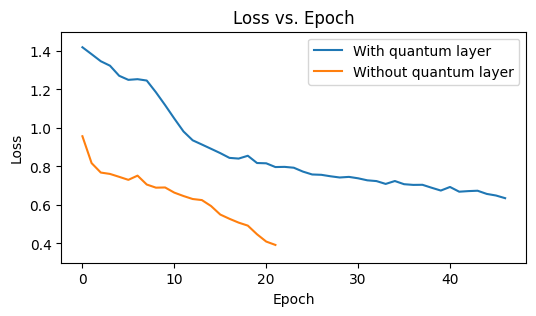

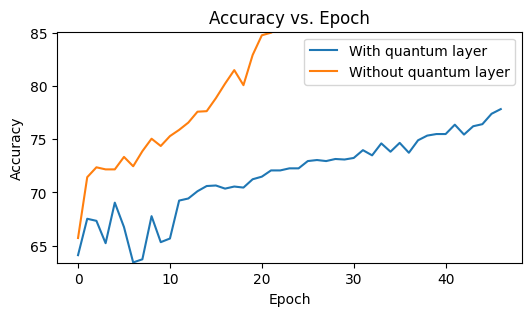

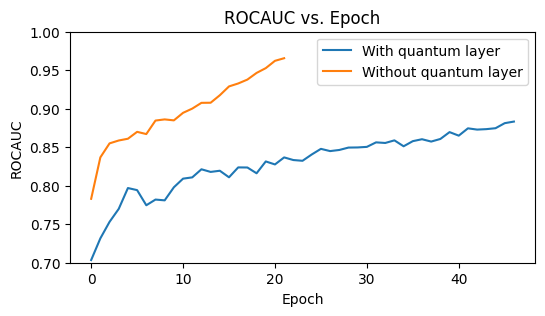

In [ ]:
plot(hybrid_train_losses, normal_train_losses, hybrid_train_accs, normal_train_accs, hybrid_train_aucs, normal_train_aucs)

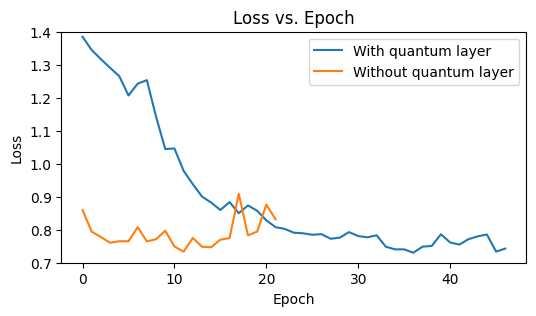

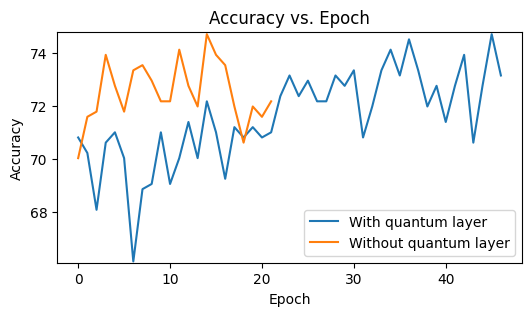

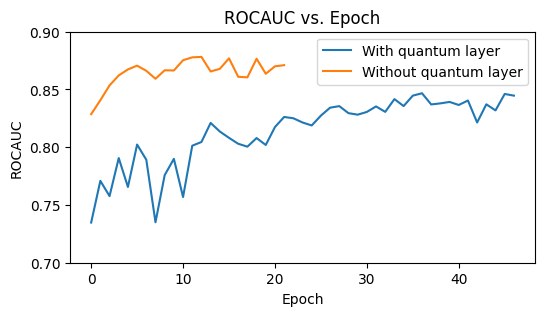

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


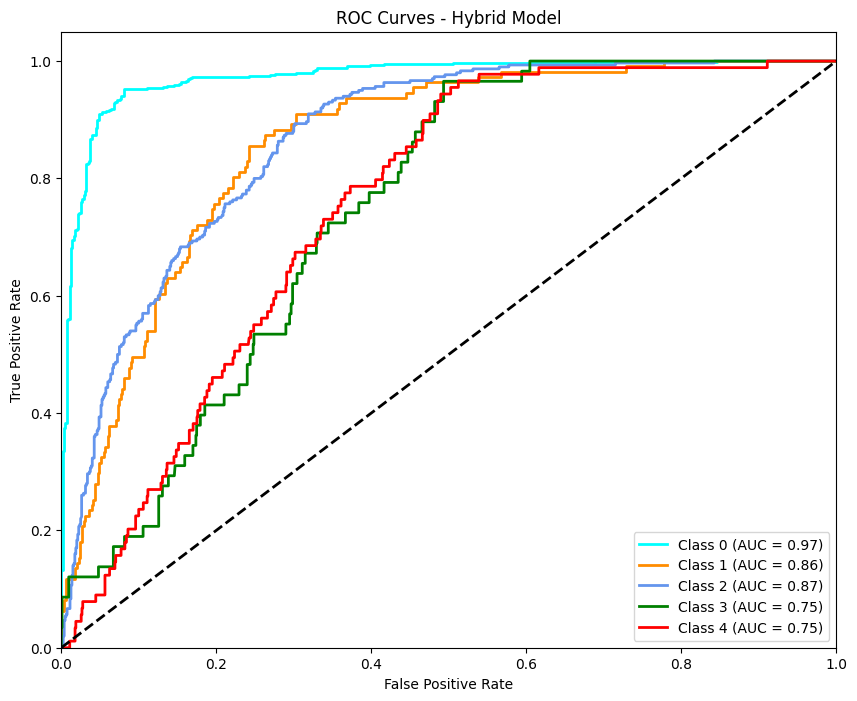

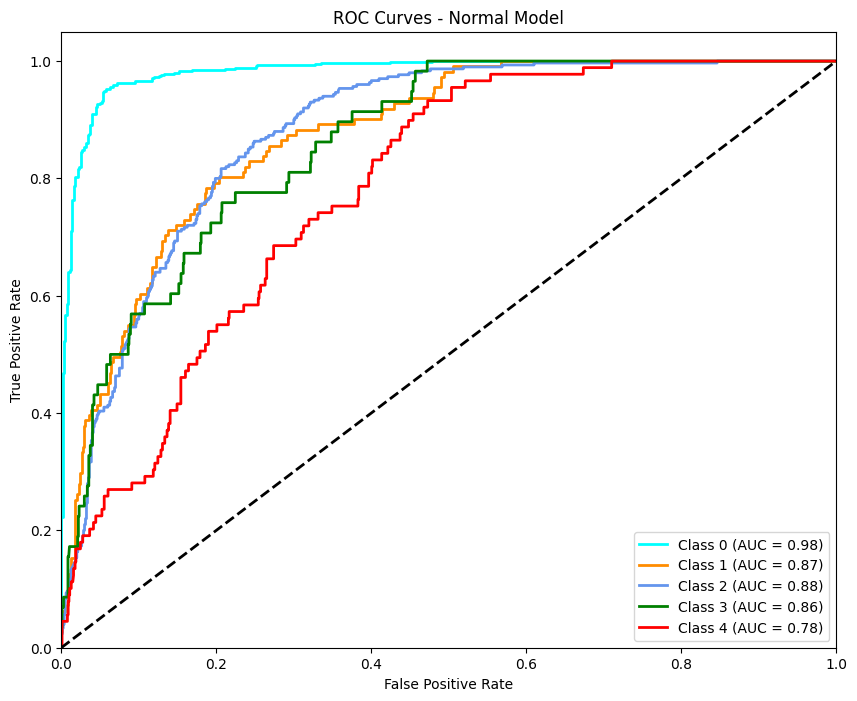


Hybrid Model Metrics:
Accuracy: 0.7155
F1 Score: 0.6770
Precision: 0.6467
Recall: 0.7155
AUROC: 0.8394

Normal Model Metrics:
Accuracy: 0.7418
F1 Score: 0.7270
Precision: 0.7200
Recall: 0.7418
AUROC: 0.8755 



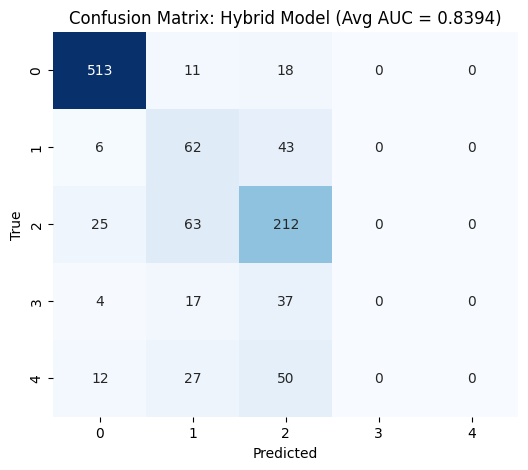

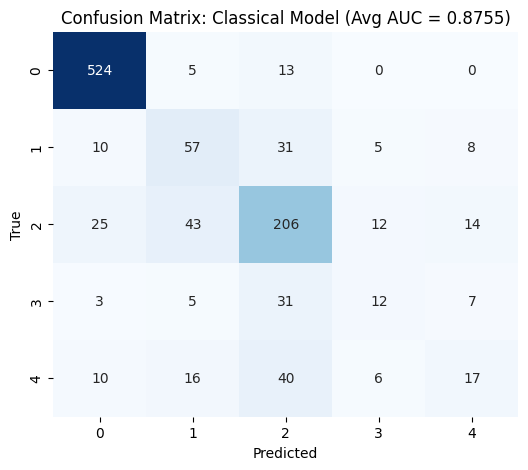

In [ ]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)

## Seed Experiment 2

In [ ]:
seed = random.randint(1, 100)
print(f"Experiment with Seed {seed}:")
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
model = NormalModel(num_classes=5)
hybrid_model = QuantumHybridModel(num_classes=5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name_hybrid = 'quantum_hybrid_model'
model_name_normal = 'normal_model'
model.to(device)
hybrid_model.to(device)

Experiment with Seed 88:


QuantumHybridModel(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (qlayer1): <Quantum Torch Layer: func=qnode>
  (qlayer2): <Quantum Torch Layer: func=qnode>
  (qlayer3): <Quantum Torch Layer: func=qnode>
  (qlayer4): <Quantum Torch Layer: func=qnode>
  (fc1): Linear(in_features=100352, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=5, bias=True)
)

In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 0.9338, Training Accuracy: 67.72%, Training AUROC: 0.7881
Validation Loss: 0.8197, Validation Accuracy: 71.98%, Validation AUROC: 0.8283
Epoch [2/100]
Training Loss: 0.8193, Training Accuracy: 70.90%, Training AUROC: 0.8286
Validation Loss: 0.8212, Validation Accuracy: 71.21%, Validation AUROC: 0.8398
Epoch [3/100]
Training Loss: 0.7980, Training Accuracy: 70.70%, Training AUROC: 0.8438
Validation Loss: 0.7939, Validation Accuracy: 72.18%, Validation AUROC: 0.8520
Epoch [4/100]
Training Loss: 0.7773, Training Accuracy: 72.41%, Training AUROC: 0.8565
Validation Loss: 0.7981, Validation Accuracy: 70.43%, Validation AUROC: 0.8551
Epoch [5/100]
Training Loss: 0.7249, Training Accuracy: 73.39%, Training AUROC: 0.8701
Validation Loss: 0.8344, Validation Accuracy: 71.98%, Validation AUROC: 0.8645
Epoch [6/100]
Training Loss: 0.7183, Training Accuracy: 72.85%, Training AUROC: 0.8774
Validation Loss: 0.7931, Validation Accuracy: 71.98%, Validation AUROC: 0.8632
Epoc

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed,
    quantum=True
)

Epoch [1/100]
Training Loss: 1.4555, Training Accuracy: 48.68%, Training AUROC: 0.6729
Validation Loss: 1.4352, Validation Accuracy: 49.22%, Validation AUROC: 0.7513
Epoch [2/100]
Training Loss: 1.4137, Training Accuracy: 49.32%, Training AUROC: 0.7629
Validation Loss: 1.3923, Validation Accuracy: 49.22%, Validation AUROC: 0.7817
Epoch [3/100]
Training Loss: 1.3823, Training Accuracy: 49.32%, Training AUROC: 0.7893
Validation Loss: 1.3598, Validation Accuracy: 49.22%, Validation AUROC: 0.8131
Epoch [4/100]
Training Loss: 1.3586, Training Accuracy: 49.32%, Training AUROC: 0.7888
Validation Loss: 1.3702, Validation Accuracy: 49.22%, Validation AUROC: 0.7421
Epoch [5/100]
Training Loss: 1.3188, Training Accuracy: 49.95%, Training AUROC: 0.7931
Validation Loss: 1.2863, Validation Accuracy: 50.97%, Validation AUROC: 0.8229
Epoch [6/100]
Training Loss: 1.2470, Training Accuracy: 58.15%, Training AUROC: 0.8259
Validation Loss: 1.2574, Validation Accuracy: 62.26%, Validation AUROC: 0.8009
Epoc

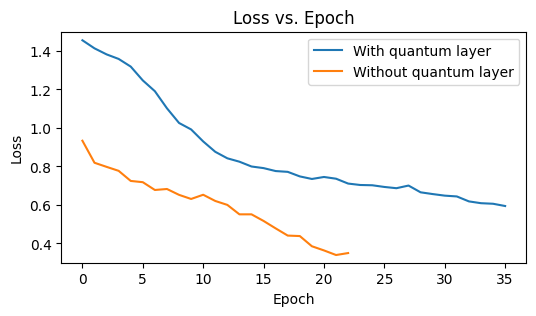

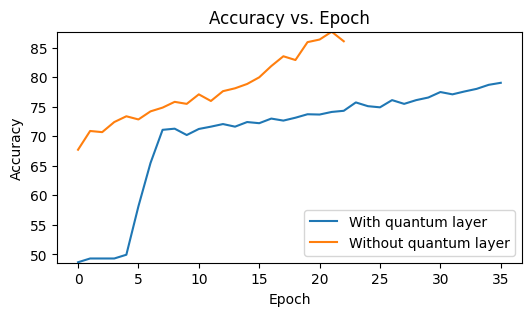

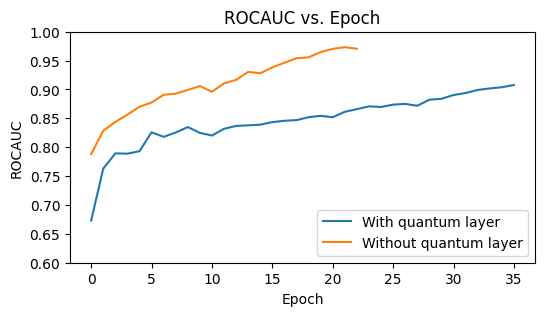

In [ ]:
plot(hybrid_train_losses, normal_train_losses, hybrid_train_accs, normal_train_accs, hybrid_train_aucs, normal_train_aucs)

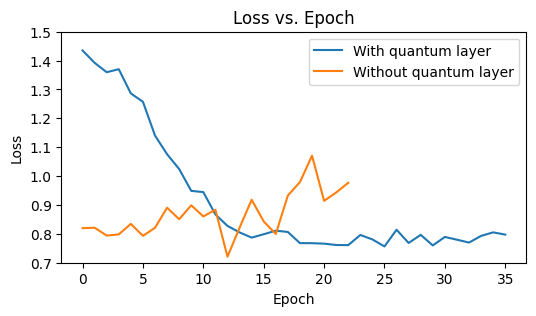

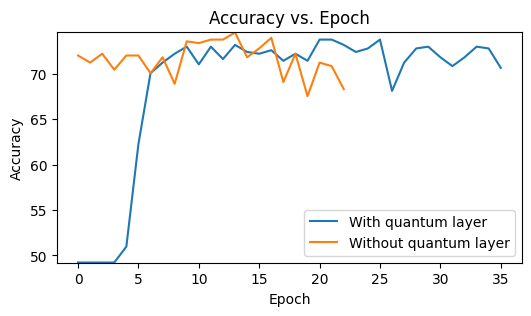

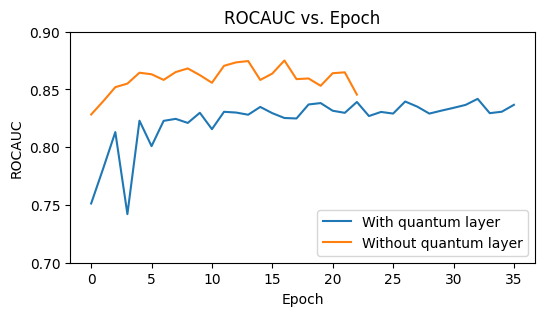

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


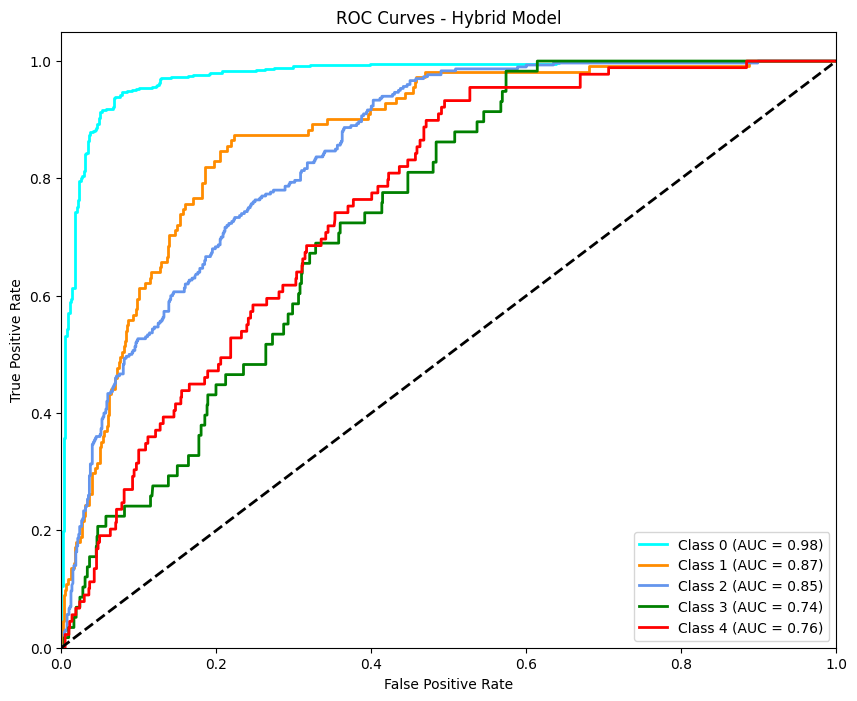

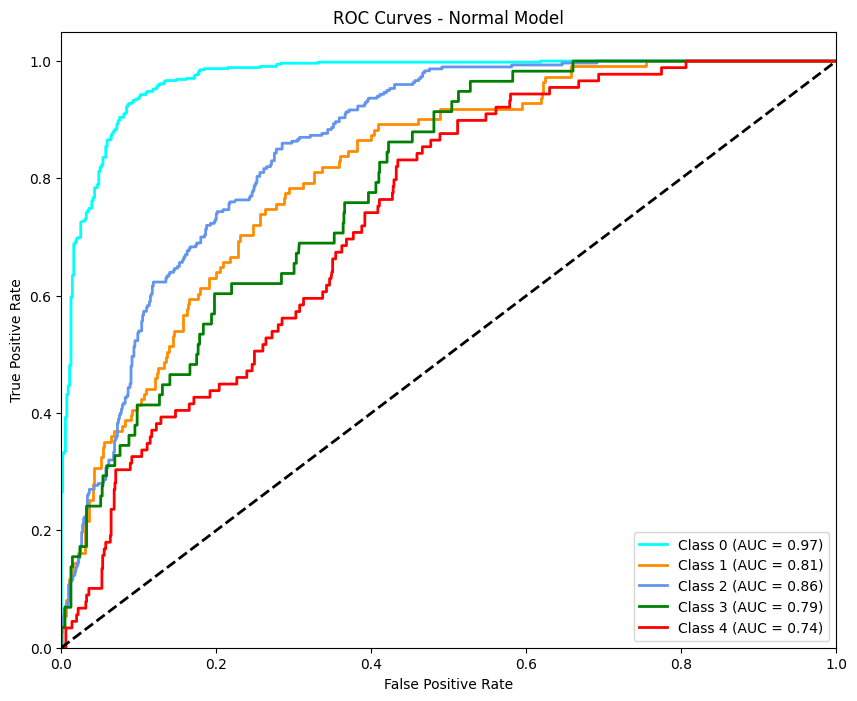


Hybrid Model Metrics:
Accuracy: 0.7018
F1 Score: 0.6695
Precision: 0.6538
Recall: 0.7018
AUROC: 0.8377

Normal Model Metrics:
Accuracy: 0.6982
F1 Score: 0.6808
Precision: 0.6725
Recall: 0.6982
AUROC: 0.8332 



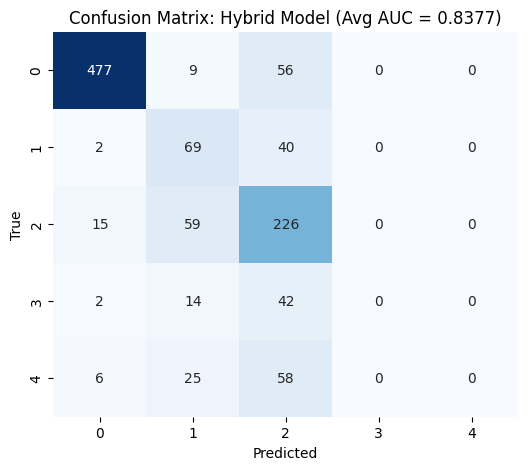

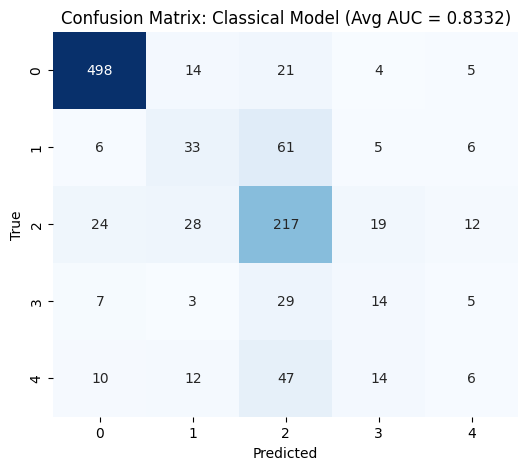

In [ ]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)

## Seed Experiment 3

In [ ]:
seed = random.randint(1, 100)
print(f"Experiment with Seed {seed}:")
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
model = NormalModel(num_classes=5)
hybrid_model = QuantumHybridModel(num_classes=5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name_hybrid = 'quantum_hybrid_model'
model_name_normal = 'normal_model'
model.to(device)
hybrid_model.to(device)

Experiment with Seed 51:


QuantumHybridModel(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (qlayer1): <Quantum Torch Layer: func=qnode>
  (qlayer2): <Quantum Torch Layer: func=qnode>
  (qlayer3): <Quantum Torch Layer: func=qnode>
  (qlayer4): <Quantum Torch Layer: func=qnode>
  (fc1): Linear(in_features=100352, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=5, bias=True)
)

In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 0.9836, Training Accuracy: 65.58%, Training AUROC: 0.7632
Validation Loss: 0.8851, Validation Accuracy: 68.29%, Validation AUROC: 0.8014
Epoch [2/100]
Training Loss: 0.8267, Training Accuracy: 71.00%, Training AUROC: 0.8286
Validation Loss: 0.8409, Validation Accuracy: 71.01%, Validation AUROC: 0.8255
Epoch [3/100]
Training Loss: 0.7815, Training Accuracy: 71.24%, Training AUROC: 0.8472
Validation Loss: 0.8123, Validation Accuracy: 71.21%, Validation AUROC: 0.8500
Epoch [4/100]
Training Loss: 0.7702, Training Accuracy: 72.12%, Training AUROC: 0.8587
Validation Loss: 0.8230, Validation Accuracy: 72.76%, Validation AUROC: 0.8282
Epoch [5/100]
Training Loss: 0.7654, Training Accuracy: 72.22%, Training AUROC: 0.8578
Validation Loss: 0.8350, Validation Accuracy: 69.65%, Validation AUROC: 0.8400
Epoch [6/100]
Training Loss: 0.7509, Training Accuracy: 72.46%, Training AUROC: 0.8587
Validation Loss: 0.7730, Validation Accuracy: 72.76%, Validation AUROC: 0.8589
Epoc

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed,
    quantum=True
)

Epoch [1/100]
Training Loss: 1.4699, Training Accuracy: 54.79%, Training AUROC: 0.6831
Validation Loss: 1.4519, Validation Accuracy: 56.42%, Validation AUROC: 0.6733
Epoch [2/100]
Training Loss: 1.4524, Training Accuracy: 58.45%, Training AUROC: 0.6834
Validation Loss: 1.4520, Validation Accuracy: 56.23%, Validation AUROC: 0.6721
Epoch [3/100]
Training Loss: 1.4442, Training Accuracy: 58.30%, Training AUROC: 0.6645
Validation Loss: 1.4256, Validation Accuracy: 56.81%, Validation AUROC: 0.6768
Epoch [4/100]
Training Loss: 1.4025, Training Accuracy: 65.28%, Training AUROC: 0.6888
Validation Loss: 1.3738, Validation Accuracy: 69.65%, Validation AUROC: 0.7240
Epoch [5/100]
Training Loss: 1.3446, Training Accuracy: 70.41%, Training AUROC: 0.7148
Validation Loss: 1.3381, Validation Accuracy: 70.82%, Validation AUROC: 0.7245
Epoch [6/100]
Training Loss: 1.2898, Training Accuracy: 71.73%, Training AUROC: 0.7312
Validation Loss: 1.2659, Validation Accuracy: 71.40%, Validation AUROC: 0.7339
Epoc

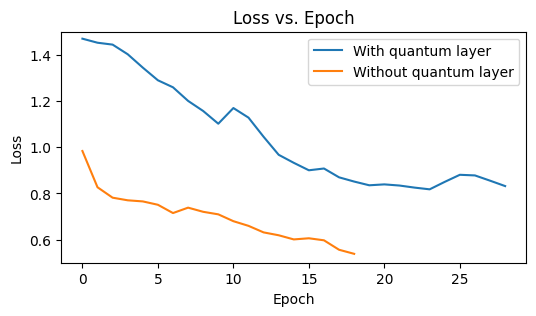

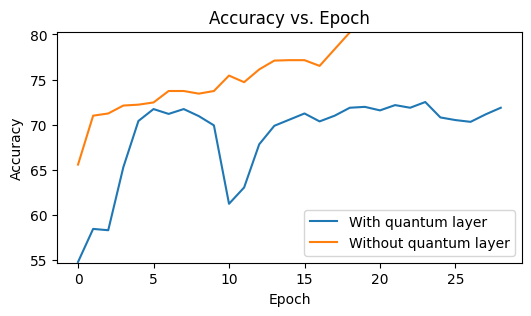

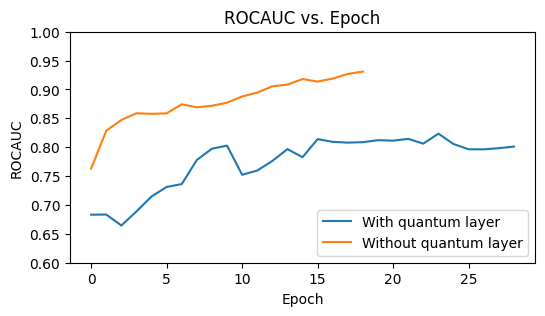

In [ ]:
plot(hybrid_train_losses, normal_train_losses, hybrid_train_accs, normal_train_accs, hybrid_train_aucs, normal_train_aucs)

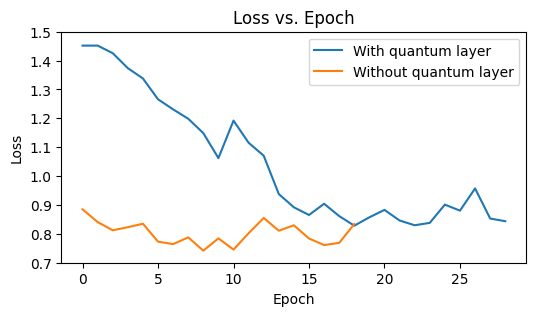

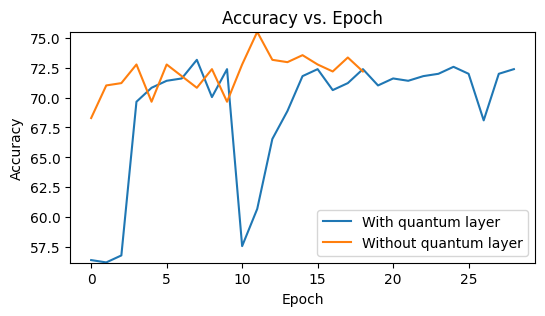

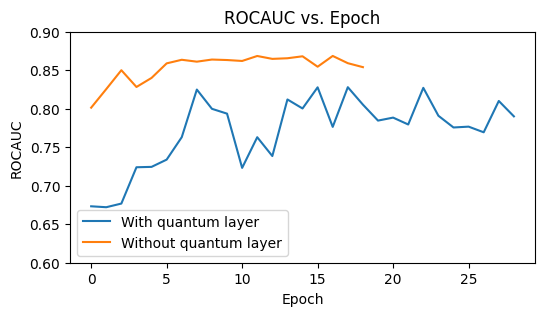

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


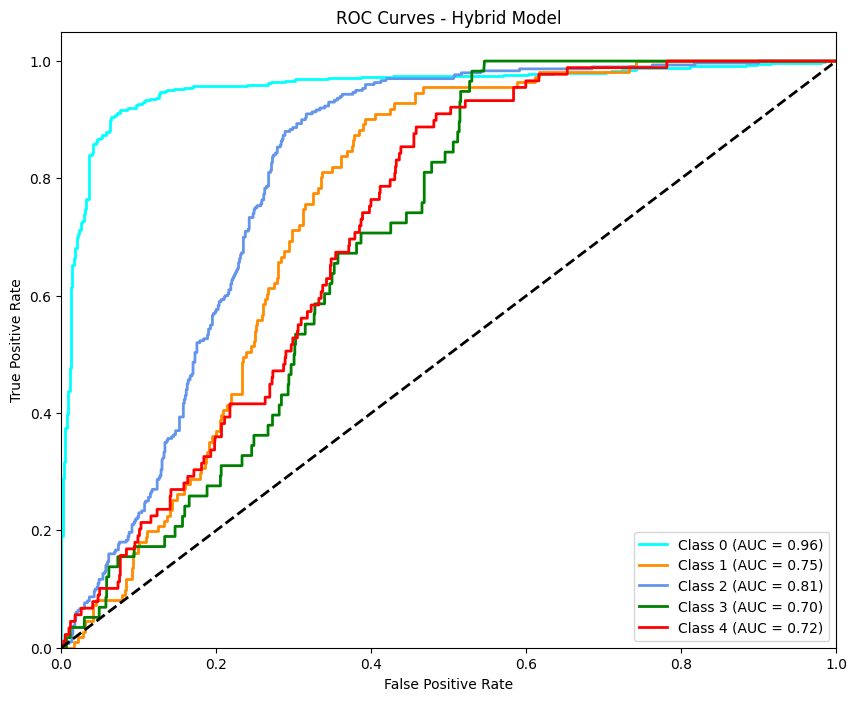

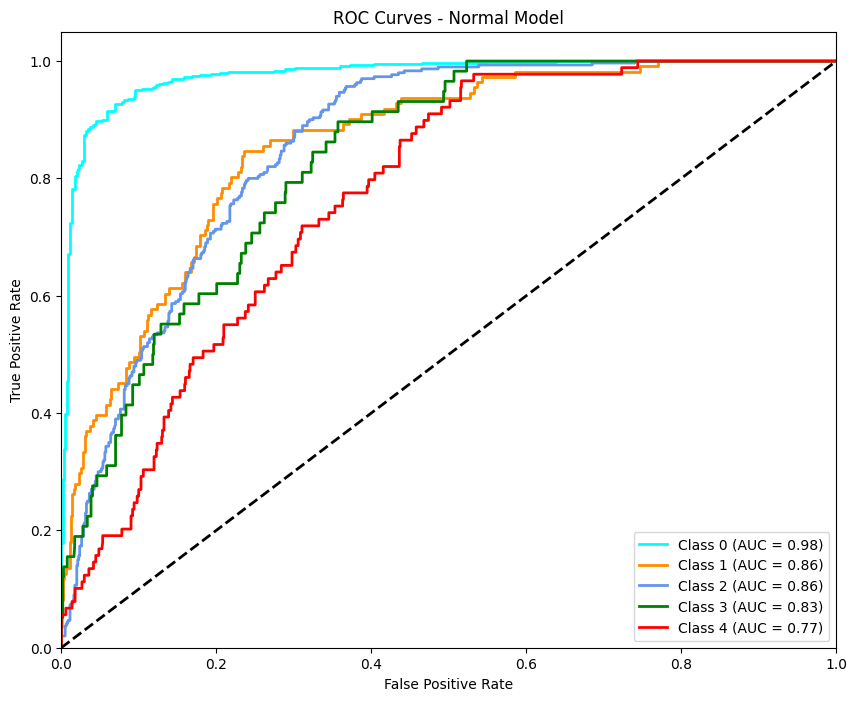


Hybrid Model Metrics:
Accuracy: 0.7045
F1 Score: 0.6286
Precision: 0.5877
Recall: 0.7045
AUROC: 0.7878

Normal Model Metrics:
Accuracy: 0.7036
F1 Score: 0.6962
Precision: 0.6975
Recall: 0.7036
AUROC: 0.8588 



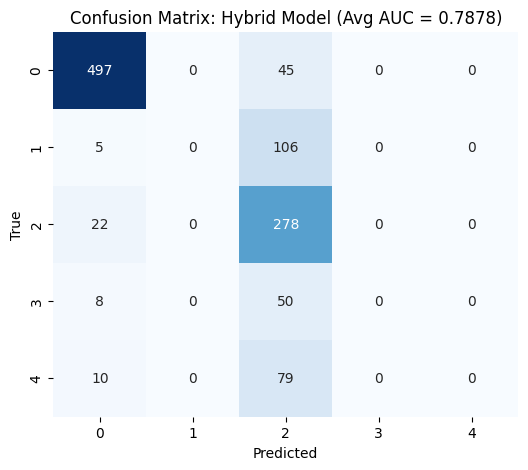

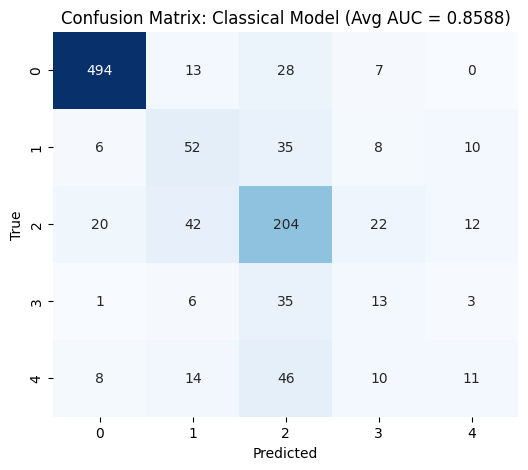

In [ ]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)

## Seed Experiment 4

In [ ]:
seed = random.randint(1, 100)
print(f"Experiment with Seed {seed}:")
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
model = NormalModel(num_classes=5)
hybrid_model = QuantumHybridModel(num_classes=5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name_hybrid = 'quantum_hybrid_model'
model_name_normal = 'normal_model'
model.to(device)
hybrid_model.to(device)

Experiment with Seed 32:


QuantumHybridModel(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (qlayer1): <Quantum Torch Layer: func=qnode>
  (qlayer2): <Quantum Torch Layer: func=qnode>
  (qlayer3): <Quantum Torch Layer: func=qnode>
  (qlayer4): <Quantum Torch Layer: func=qnode>
  (fc1): Linear(in_features=100352, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=5, bias=True)
)

In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_load0er=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 0.9897, Training Accuracy: 65.72%, Training AUROC: 0.7507
Validation Loss: 0.8447, Validation Accuracy: 71.21%, Validation AUROC: 0.8162
Epoch [2/100]
Training Loss: 0.8396, Training Accuracy: 70.46%, Training AUROC: 0.8270
Validation Loss: 0.8014, Validation Accuracy: 72.57%, Validation AUROC: 0.8462
Epoch [3/100]
Training Loss: 0.7759, Training Accuracy: 72.41%, Training AUROC: 0.8508
Validation Loss: 0.8589, Validation Accuracy: 70.62%, Validation AUROC: 0.8279
Epoch [4/100]
Training Loss: 0.7607, Training Accuracy: 71.68%, Training AUROC: 0.8584
Validation Loss: 0.7875, Validation Accuracy: 71.40%, Validation AUROC: 0.8553
Epoch [5/100]
Training Loss: 0.7713, Training Accuracy: 72.75%, Training AUROC: 0.8551
Validation Loss: 0.7696, Validation Accuracy: 72.37%, Validation AUROC: 0.8550
Epoch [6/100]
Training Loss: 0.7383, Training Accuracy: 73.49%, Training AUROC: 0.8648
Validation Loss: 0.7849, Validation Accuracy: 70.82%, Validation AUROC: 0.8525
Epoc

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed,
    quantum=True
)

Epoch [1/100]
Training Loss: 1.4657, Training Accuracy: 63.72%, Training AUROC: 0.6913
Validation Loss: 1.4336, Validation Accuracy: 71.01%, Validation AUROC: 0.6653
Epoch [2/100]
Training Loss: 1.4331, Training Accuracy: 69.09%, Training AUROC: 0.7178
Validation Loss: 1.4190, Validation Accuracy: 67.32%, Validation AUROC: 0.7315
Epoch [3/100]
Training Loss: 1.3904, Training Accuracy: 69.73%, Training AUROC: 0.7430
Validation Loss: 1.3726, Validation Accuracy: 71.79%, Validation AUROC: 0.7216
Epoch [4/100]
Training Loss: 1.3358, Training Accuracy: 71.48%, Training AUROC: 0.7417
Validation Loss: 1.3049, Validation Accuracy: 71.40%, Validation AUROC: 0.7527
Epoch [5/100]
Training Loss: 1.2694, Training Accuracy: 71.44%, Training AUROC: 0.7741
Validation Loss: 1.2180, Validation Accuracy: 72.76%, Validation AUROC: 0.7461
Epoch [6/100]
Training Loss: 1.1922, Training Accuracy: 71.78%, Training AUROC: 0.7808
Validation Loss: 1.1401, Validation Accuracy: 72.76%, Validation AUROC: 0.8148
Epoc

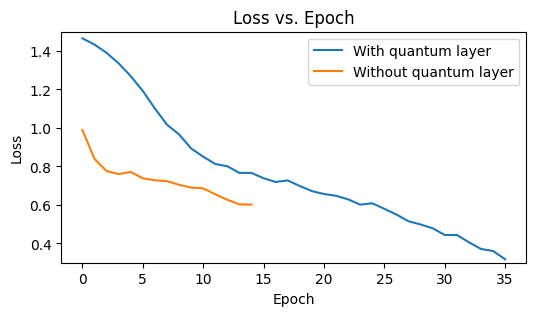

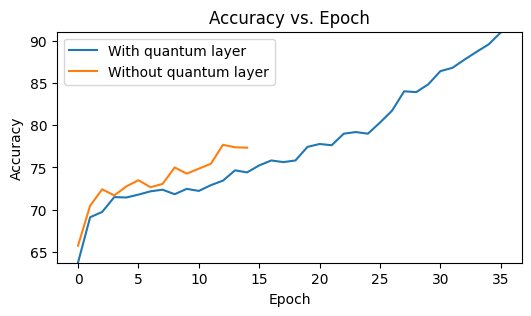

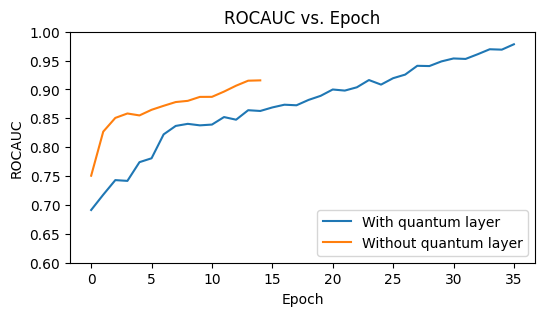

In [ ]:
plot(hybrid_train_losses, normal_train_losses, hybrid_train_accs, normal_train_accs, hybrid_train_aucs, normal_train_aucs)

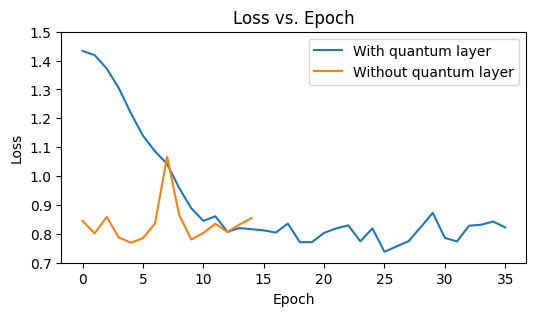

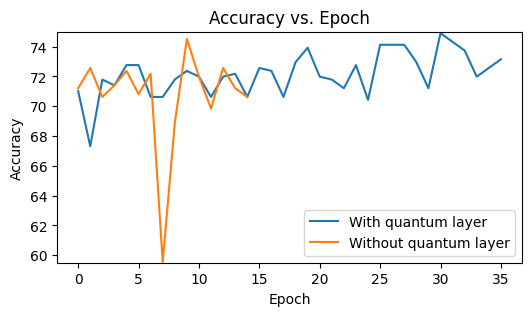

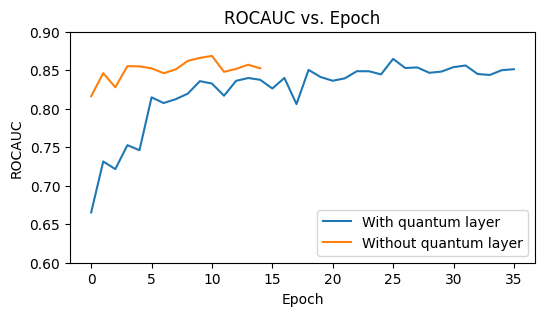

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

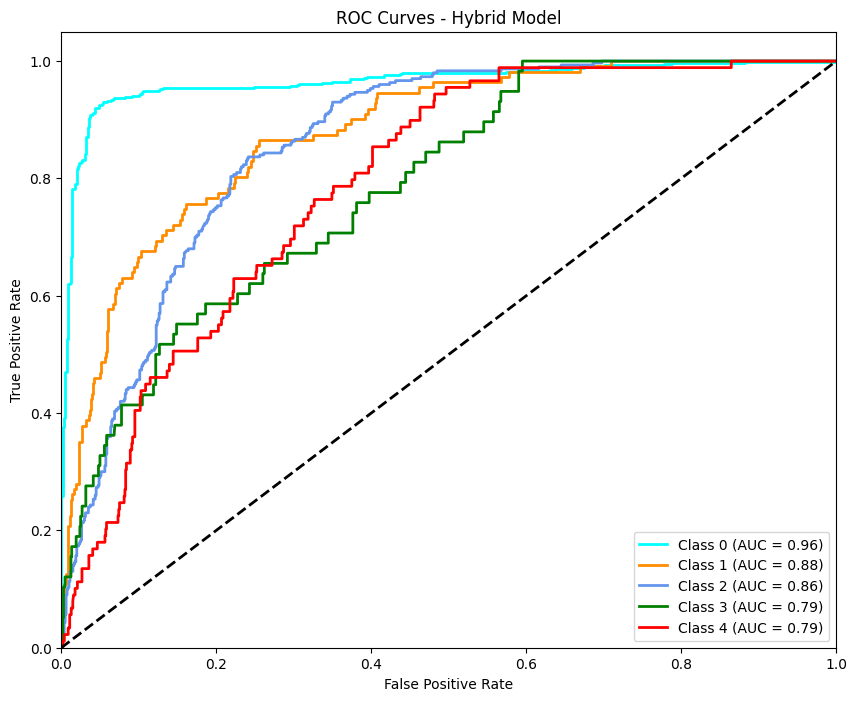

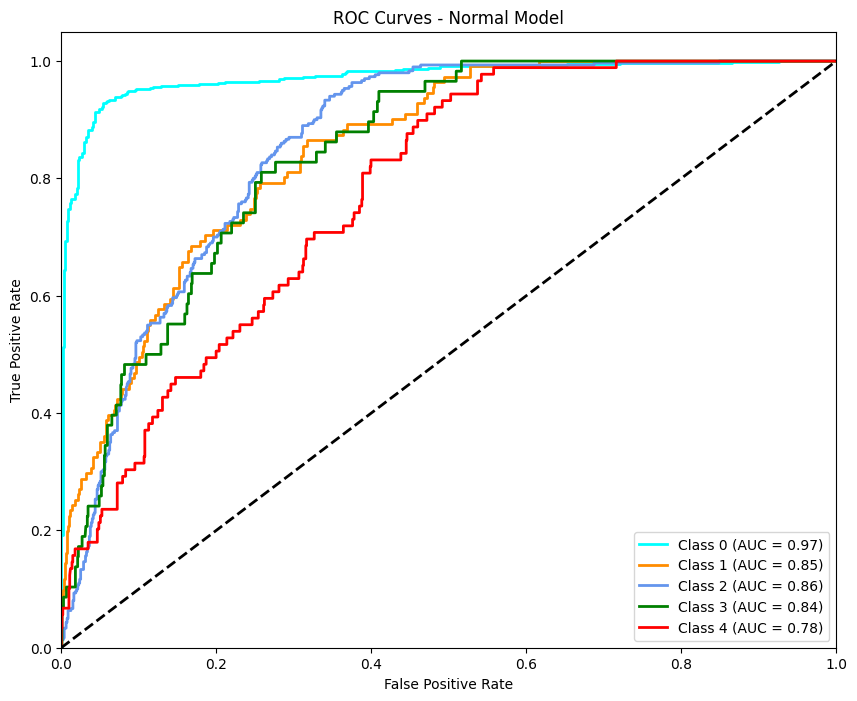


Hybrid Model Metrics:
Accuracy: 0.7282
F1 Score: 0.7178
Precision: 0.7160
Recall: 0.7282
AUROC: 0.8564

Normal Model Metrics:
Accuracy: 0.6982
F1 Score: 0.6830
Precision: 0.7375
Recall: 0.6982
AUROC: 0.8594 



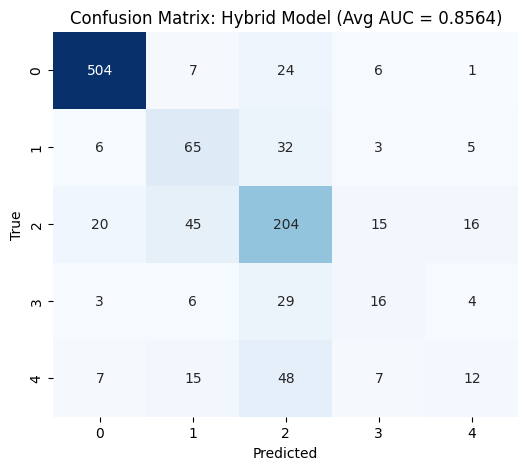

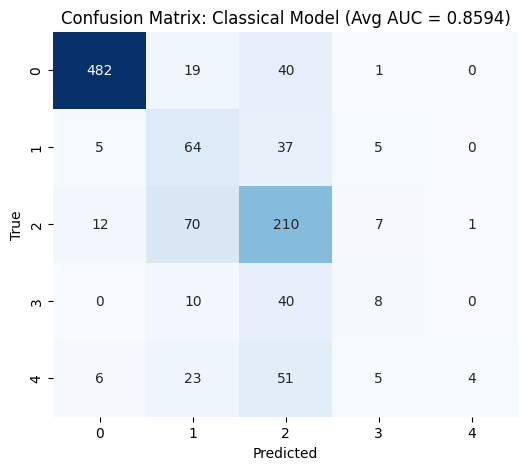

In [ ]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)

## Seed Experiment 5

In [ ]:
seed = random.randint(1, 100)
print(f"Experiment with Seed {seed}:")
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
model = NormalModel(num_classes=5)
hybrid_model = QuantumHybridModel(num_classes=5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name_hybrid = 'quantum_hybrid_model'
model_name_normal = 'normal_model'
model.to(device)
hybrid_model.to(device)

Experiment with Seed 10:


QuantumHybridModel(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (qlayer1): <Quantum Torch Layer: func=qnode>
  (qlayer2): <Quantum Torch Layer: func=qnode>
  (qlayer3): <Quantum Torch Layer: func=qnode>
  (qlayer4): <Quantum Torch Layer: func=qnode>
  (fc1): Linear(in_features=100352, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=5, bias=True)
)

In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 0.9696, Training Accuracy: 64.84%, Training AUROC: 0.7760
Validation Loss: 0.8270, Validation Accuracy: 71.60%, Validation AUROC: 0.8292
Epoch [2/100]
Training Loss: 0.8336, Training Accuracy: 70.70%, Training AUROC: 0.8290
Validation Loss: 0.7935, Validation Accuracy: 71.40%, Validation AUROC: 0.8457
Epoch [3/100]
Training Loss: 0.7660, Training Accuracy: 71.39%, Training AUROC: 0.8563
Validation Loss: 0.8391, Validation Accuracy: 71.21%, Validation AUROC: 0.8299
Epoch [4/100]
Training Loss: 0.7698, Training Accuracy: 72.31%, Training AUROC: 0.8560
Validation Loss: 0.7850, Validation Accuracy: 72.57%, Validation AUROC: 0.8635
Epoch [5/100]
Training Loss: 0.7380, Training Accuracy: 73.88%, Training AUROC: 0.8663
Validation Loss: 0.7929, Validation Accuracy: 72.96%, Validation AUROC: 0.8710
Epoch [6/100]
Training Loss: 0.7277, Training Accuracy: 73.58%, Training AUROC: 0.8698
Validation Loss: 0.8110, Validation Accuracy: 71.98%, Validation AUROC: 0.8442
Epoc

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed,
    quantum=True
)

Epoch [1/100]
Training Loss: 1.4592, Training Accuracy: 63.96%, Training AUROC: 0.6988
Validation Loss: 1.4324, Validation Accuracy: 70.82%, Validation AUROC: 0.7635
Epoch [2/100]
Training Loss: 1.4297, Training Accuracy: 69.68%, Training AUROC: 0.7701
Validation Loss: 1.4236, Validation Accuracy: 69.26%, Validation AUROC: 0.7439
Epoch [3/100]
Training Loss: 1.4061, Training Accuracy: 69.87%, Training AUROC: 0.7928
Validation Loss: 1.3927, Validation Accuracy: 71.98%, Validation AUROC: 0.7530
Epoch [4/100]
Training Loss: 1.3809, Training Accuracy: 70.90%, Training AUROC: 0.8084
Validation Loss: 1.3871, Validation Accuracy: 65.37%, Validation AUROC: 0.7459
Epoch [5/100]
Training Loss: 1.3553, Training Accuracy: 69.43%, Training AUROC: 0.7819
Validation Loss: 1.3178, Validation Accuracy: 71.60%, Validation AUROC: 0.8330
Epoch [6/100]
Training Loss: 1.2897, Training Accuracy: 71.24%, Training AUROC: 0.8196
Validation Loss: 1.2581, Validation Accuracy: 71.40%, Validation AUROC: 0.8254
Epoc

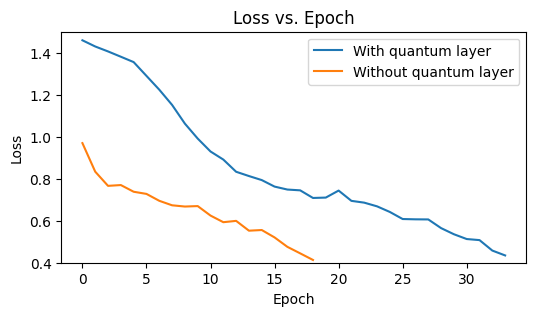

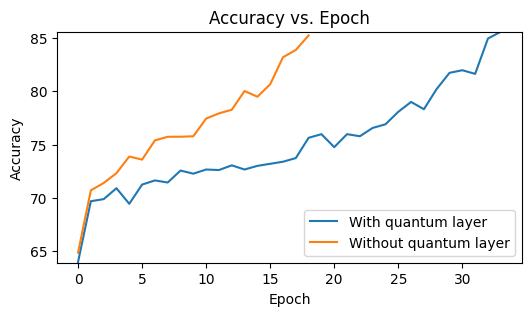

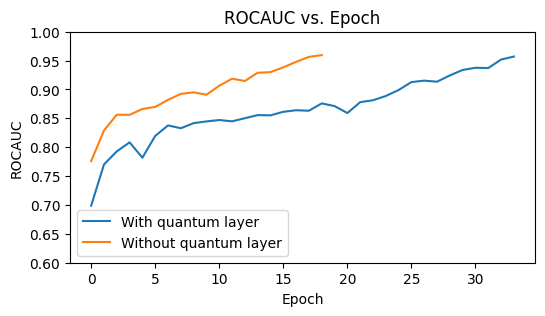

In [ ]:
plot(hybrid_train_losses, normal_train_losses, hybrid_train_accs, normal_train_accs, hybrid_train_aucs, normal_train_aucs)

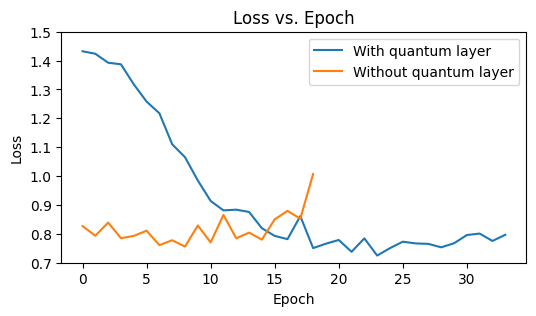

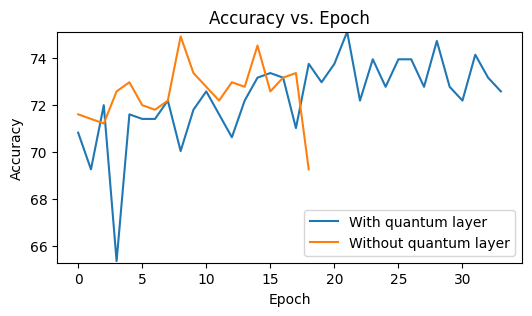

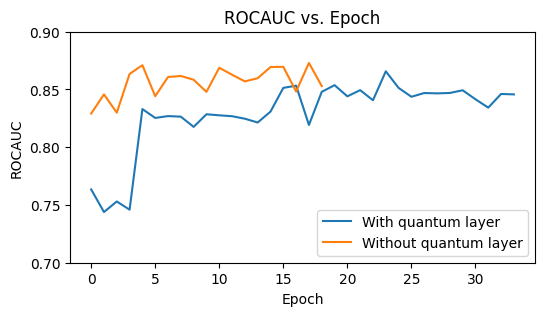

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

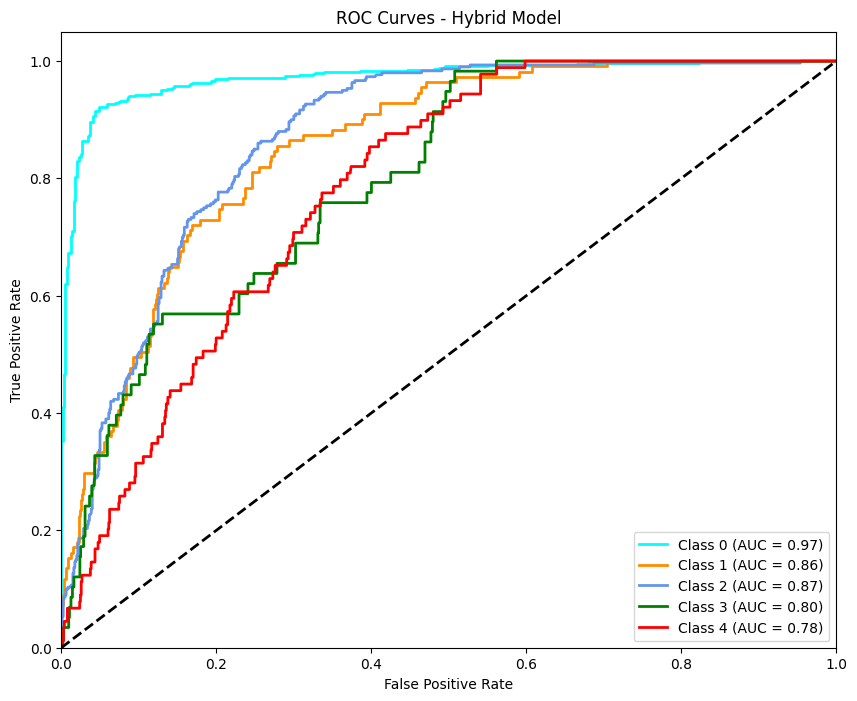

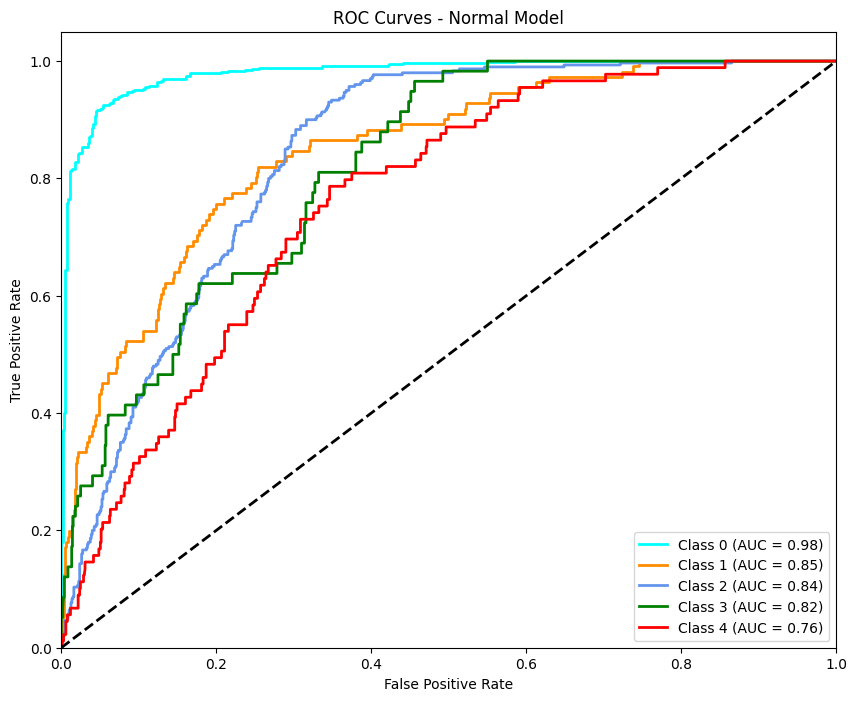


Hybrid Model Metrics:
Accuracy: 0.7218
F1 Score: 0.6955
Precision: 0.7024
Recall: 0.7218
AUROC: 0.8565

Normal Model Metrics:
Accuracy: 0.7055
F1 Score: 0.6755
Precision: 0.7297
Recall: 0.7055
AUROC: 0.8498 



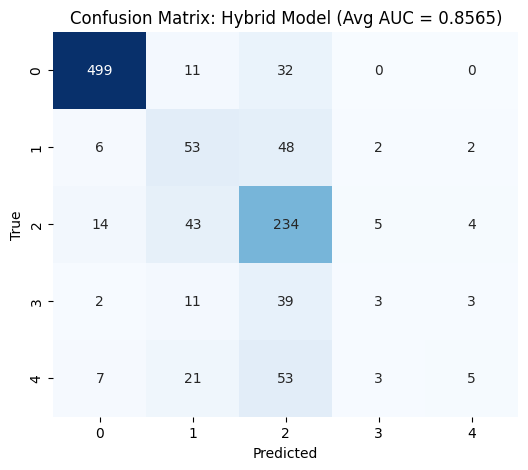

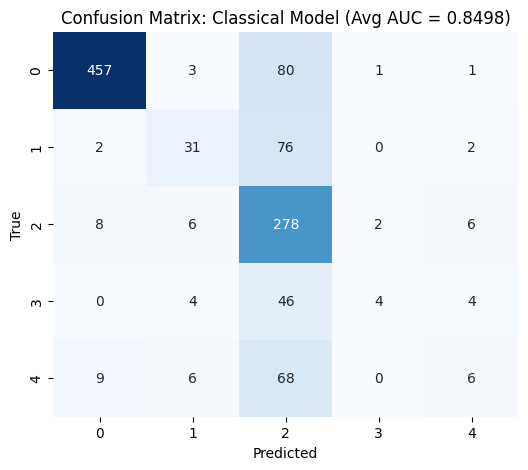

In [ ]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)